# Basic Fit - NGC 337

Using the Dale et al. (2017) photometry, fit the SED of NGC 337 with a basic model that would have been the default model in IDL Lightning.

## Imports

In [7]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('lightning.plots.style.lightning-serif')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior, ConstantPrior

## Initialization

We read in the photometry and information like the distance from a `fits` file and load it into Lightning:

In [2]:
cat = Table.read('../photometry/ngc337_dale17_photometry.fits')

# Housekeeping to load the photometry:
# strings come in as bytestrings (unencoded)
# The labels are also padded with spaces
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

lgh = Lightning(filter_labels, 
              lum_dist=dl, 
              stellar_type='PEGASE',
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              model_unc=0.10,
              print_setup_time=True)

lgh.flux_obs = fnu_obs * 1e3
lgh.flux_unc = fnu_unc * 1e3

# We could save the configuration like so:
# lgh.save_pickle('ngc337_config.pkl')

0.023 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
0.558 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.141 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
0.722 s elapsed total


Display the parameters and their allowed ranges. This is often useful to do when using a new model configuration for the first time, since the order of the parameters here is the same as that expected when defining the priors and the initial state for the MCMC.

In [3]:
lgh.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Pegase-Stellar
Parameter    Lo  Hi                                      Description
--------- ----- --- ------------------------------------------------
     Zmet 0.001 0.1 Metallicity (mass fraction, where solar = 0.020)

Modified-Calzetti
      Parameter   Lo                 Hi                                                                                Description
--------------- ---- ------------------ ------------------------------------------------------------------------------------------
mcalz_tauV_diff  0.0                inf                                                           Optical depth of the diffuse ISM
    mcalz_delta -inf 0.4473684210526316 Devi

In [4]:
p = np.array([1,1,1,1,1,
              0.02,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant; lightning doesn't yet
# completely recognize the ConstantPrior prior.
const_dim = np.array([False, False, False, False, False,
                      True,
                      False, False, True,
                      True, False, True, False, False])

# This is a little tedious 
priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          ConstantPrior([0.02]), # Metallicity
          UniformPrior([0, 3]), # tauV
          UniformPrior([-2.3, 0.4]), # delta
          ConstantPrior([0.0]), # tauV birth cloud
          ConstantPrior([2]), # alpha
          UniformPrior([0.1, 25]), # Umin
          ConstantPrior([3e5]), # Umax
          UniformPrior([0,1]),
          UniformPrior([0.0047, 0.0458])]

var_dim = ~const_dim

Nwalkers = 64

# Sample an initial state from the priors
p0s = [pr.sample(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=-1)

In [6]:
# Will print a tqdm progress bar 
mcmc = lgh.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=20000, priors=priors, const_dim=const_dim)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:15<00:00, 36.01it/s]


A first diagnostic of the MCMC is the acceptance fraction, which should typically be $>0.2$ and $<0.50$.

In [8]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))

MCMC mean acceptance fraction: 0.320


We automatically construct chopped/thinned/flattened chains based on the autocorrelation times of the chains, and retain the last 1000 samples. If we instead got a message here that the autocorrelation times were too long, we could:
- Provide a manual scale for burn-in and thinning
- Re-run the whole MCMC (expensive)
- Simply continue the MCMC where it left off by doing mcmc.run_mcmc(None, Nsteps).

We pass the `const_dim` mask and the corresponding values to `lgh.get_mcmc_chains` so that our reconstructed chain reflects all the parameters (neither `mcmc` nor `lgh` know anything themselves about which parameters were constant or at which value).

In [9]:
chain, logprob_chain, tau_ac = lgh.get_mcmc_chains(mcmc,
                                                   discard=None,
                                                   thin=None,
                                                   const_dim=const_dim,
                                                   const_vals=p[const_dim])

The values of the autocorrelation times are not really actionable as long as they're shorter than N/50. They can be used to estimate the MCMC error.

In [10]:
print(tau_ac)
print('Nsteps / 50 = %.2f' % (20000 / 50))

[209.34885177 207.31193192 260.32005758 196.37997666 237.1466256
 181.17688573 261.2378974  141.07647201 117.29100567 178.92168379]
Nsteps / 50 = 400.00


Here we could save a checkpoint by outputting the chains. Note that we already saved the configuration in a pickle file at the beginning of this notebook.

In [11]:
# with h5py.File('ngc337_chains.hdf5', 'w') as f:
#     f.create_dataset('mcmc/samples', data=chain)
#     f.create_dataset('mcmc/logprob_samples', data=logprob_chain)

In [12]:
# with h5py.File('ngc337_chains.hdf5', 'r') as f:
#     chain = f['mcmc/samples'][:,:]
#     logprob_chain = f['mcmc/logprob_samples'][:]

## Plots

Now we can visualize the results using the new builtin plotting functions. Note that each of the plotting functions looks for a Lightning object as the first argument and then the parameters (and possibly log probability chain) as the second (third) arguments. Each of the plotting functions return a tuple containing the figure and axes drawn, with the exception of `corner_plot`, which returns only the figure (being a thin wrapper around `corner.corner`).

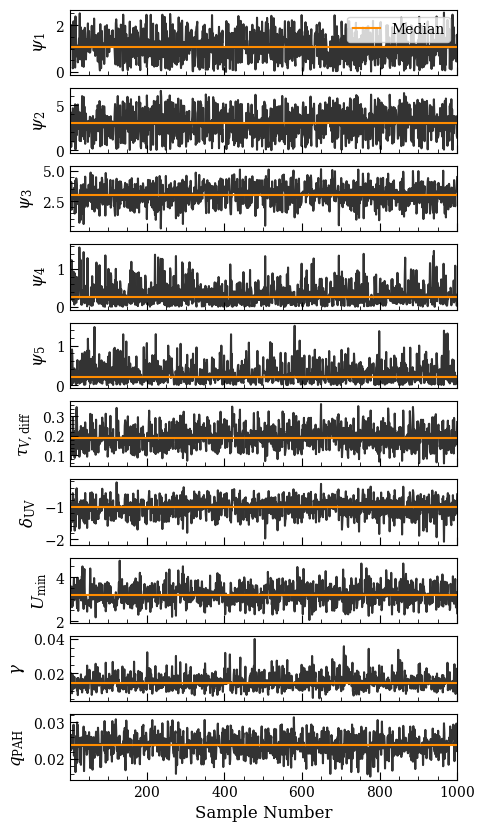

In [13]:
fig, axs = lgh.chain_plot(chain, color='black', alpha=0.8)

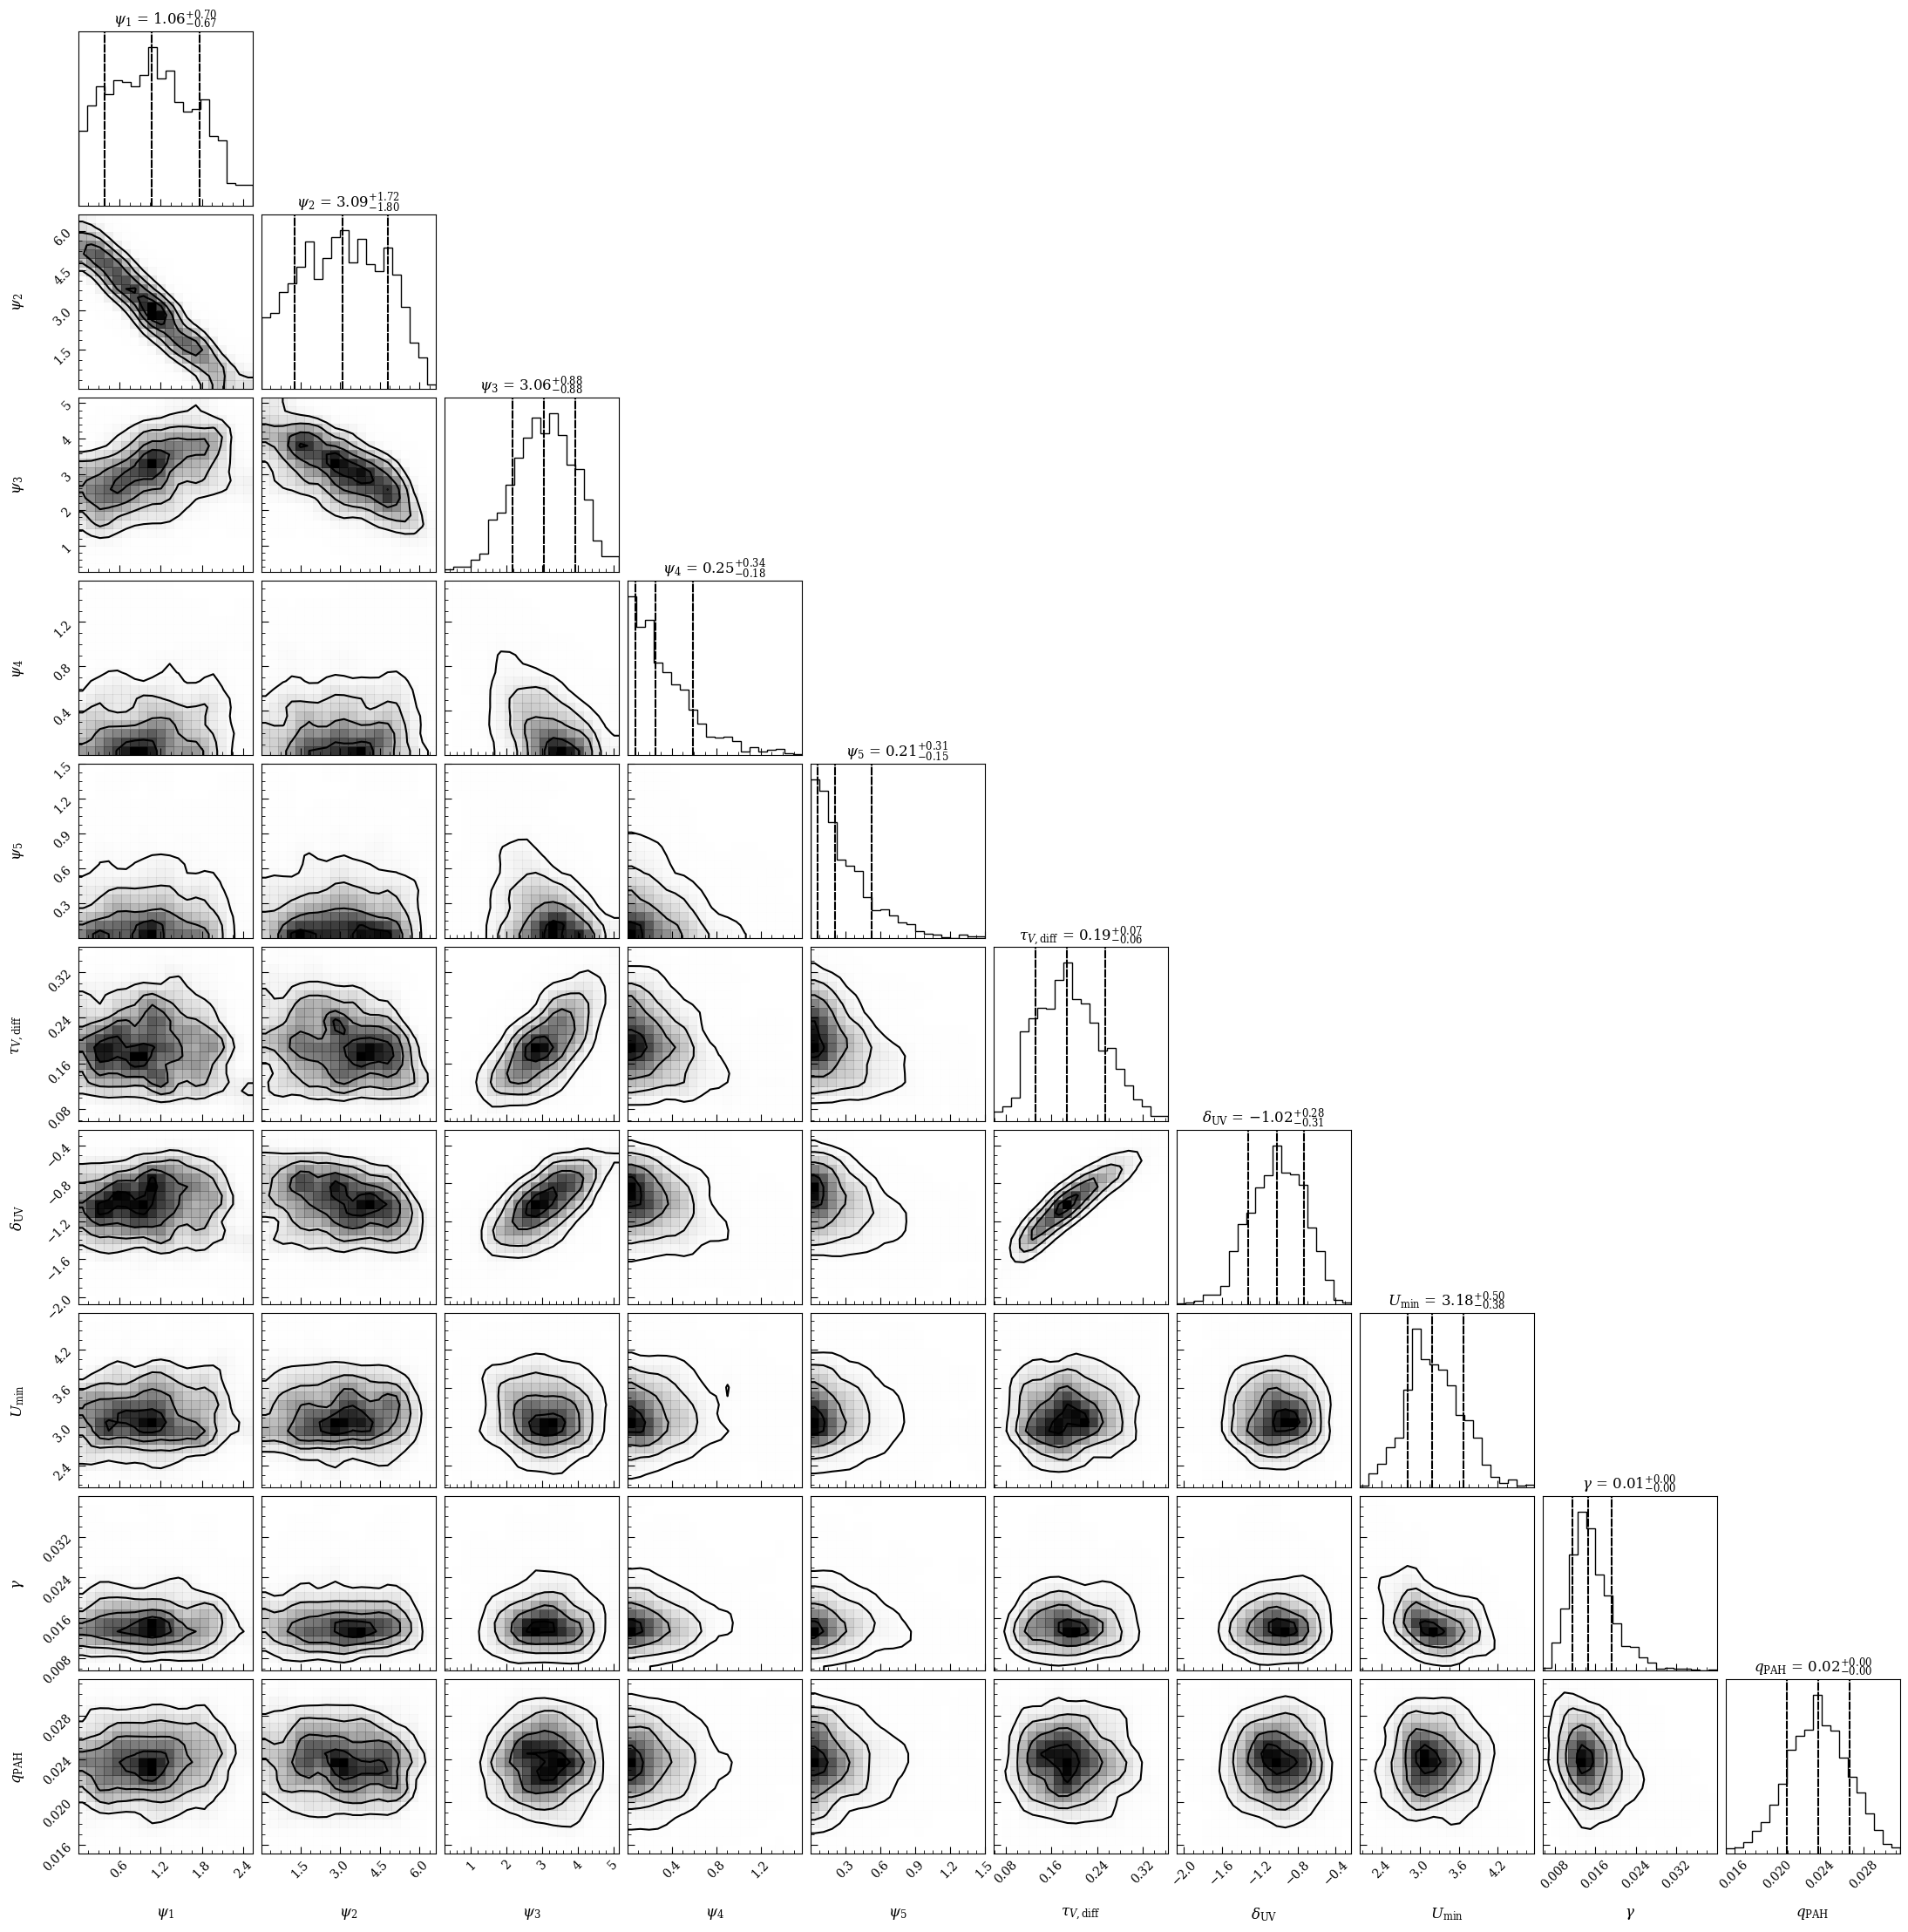

In [14]:
fig = lgh.corner_plot(chain, 
                    quantiles=(0.16, 0.50, 0.84),
                    smooth=1,
                    levels=None,
                    show_titles=True)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


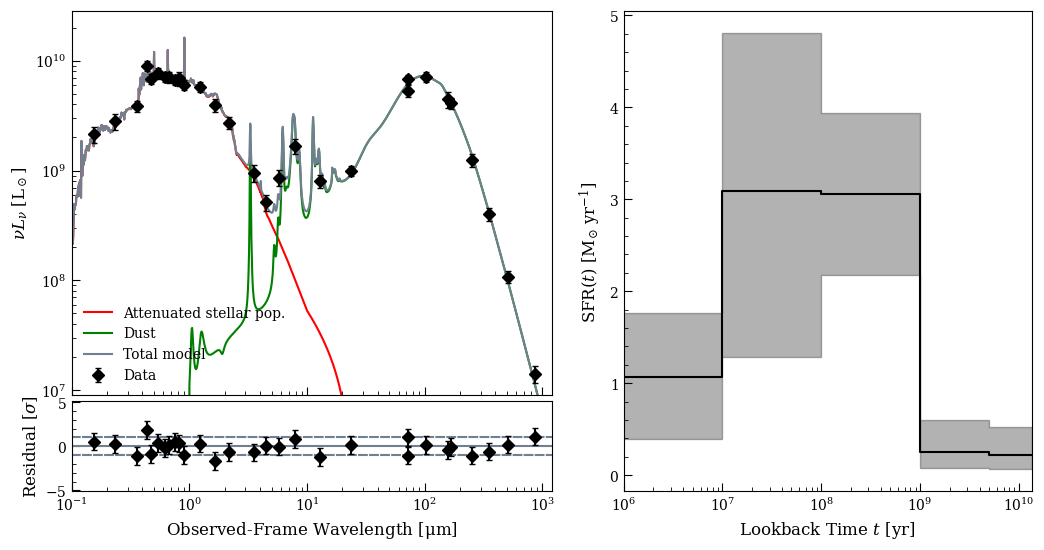

In [15]:
# from lightning.plots import sed_plot_bestfit, sed_plot_delchi, sfh_plot

# We could use the builtin plotting functions to make individual figures...
# fig1, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain, plot_components=True)
# fig2, ax2 = sed_plot_delchi(l, param_arr, logprob_chain)
# fig3, ax3 = sfh_plot(l, param_arr)

# Or we can use them to make a complex publication quality 
# figure by laying out our axes and then using the `ax` keyword in each function:
fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

fig4, ax41 = lgh.sed_plot_bestfit(chain, logprob_chain,
                                plot_components=True,
                                ax=ax41,
                                legend_kwargs={'loc': 'lower left', 'frameon': False})
ax41.set_xticklabels([])
fig4, ax42 = lgh.sed_plot_delchi(chain, logprob_chain, ax=ax42)
fig4, ax43 = lgh.sfh_plot(chain, ax=ax43)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


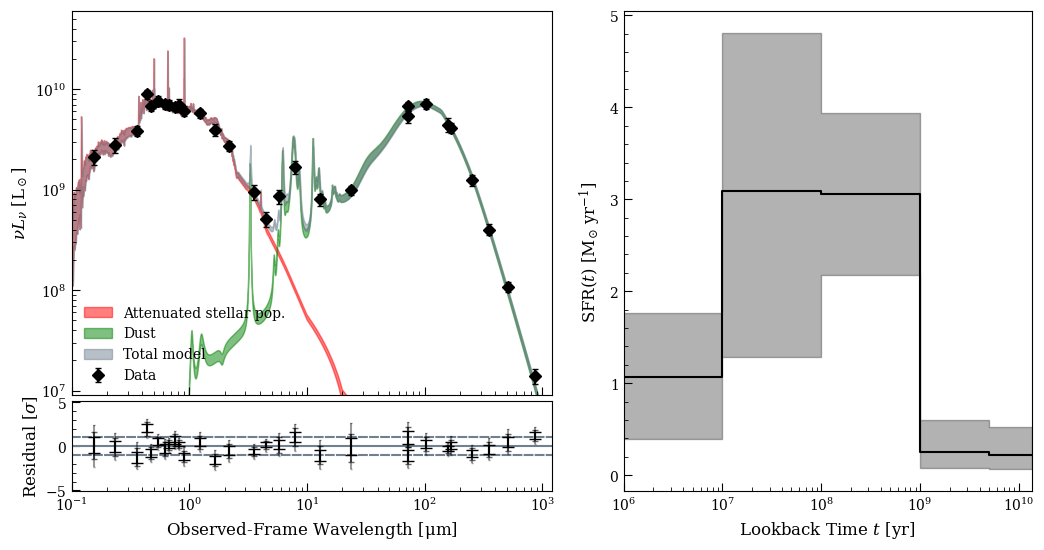

In [18]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'lower left', 'frameon': False})
ax51.set_xticklabels([])
fig5, ax52 = sed_plot_delchi_morebayesian(lgh, chain, logprob_chain, ax=ax52)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

### Goodness of Fit

We've seen that we obtained chains without any obvious correlated behavior and fairly nice unimodal posteriors, and we've seen that our normalized residuals look reasonable. We can also use the built-in posterior predictive check functions to see how well our model can reproduce the data.

The two plots are two different ways of visualizing the PPC: the first shows you where the model can and cant reproduce the data (effectively, $p-$values for each bandpass) and the second shows the definition of the total $p-$value - the fraction of Monte Carlo experiments producing worse $\chi^2$ than we observe.

/Users/eqm5663/Research/code/plightning/lightning/ppc.py:77: RuntimeWarning: invalid value encountered in divide
  chi2_rep = np.nansum((Lmod - Lmod_perturbed)**2 / total_unc2, axis=-1)


p = 0.823


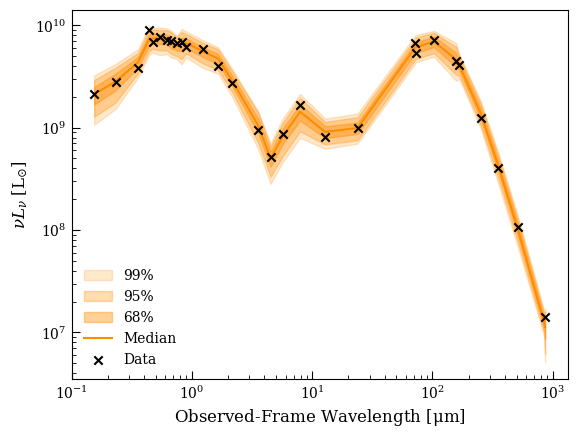

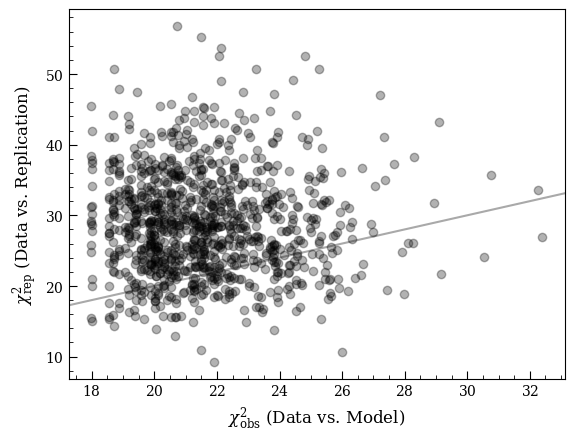

In [19]:
from lightning.ppc import ppc, ppc_sed
 
pvalue, chi2_rep, chi2_obs = ppc(lgh, chain,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(lgh, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

We can see that the model has trouble reproducing one $B-$band point near the 4000 Å break ($p \sim 0.05$ based on the shaded bands) but otherwise we do quite well. It's worth examining both these plots to see if a low $p-$value is driven only by one or two bands, or one component of the model.

We can also plot the PPC-SED plot normalized to the median, which can make individual $p-$values clearer:

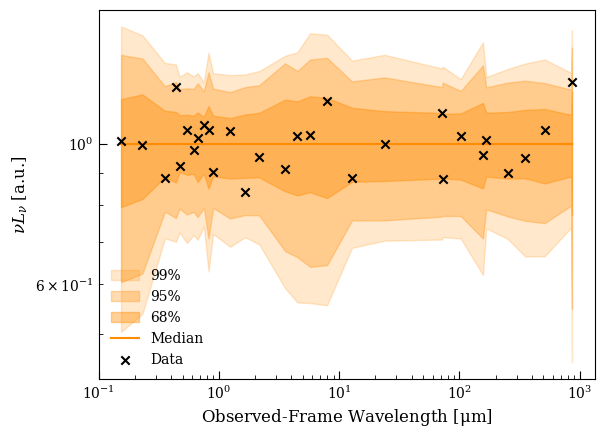

In [20]:
fig, ax = ppc_sed(lgh, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=True)

## Fit with BFGS

Now we fit with the optimization scheme. For this method we provide a single starting point and bounds for the minimizer, as a list of tuples. Constant parameters should have their bounds equal.

In [21]:
p0 = np.array([5,5,0,0,0,
               0.020,
               0.1, -1.0, 0.0,
               2, 3, 3e5, 0.01, 0.02])

bounds = [(0,10),
          (0,10),
          (0,10),
          (0,10),
          (0,10),
          (0.020, 0.020),
          (0,3),
          (-2.3,0.4),
          (0,0),
          (2,2),
          (0.1,25),
          (3e5,3e5),
          None,
          None]

res = lgh.fit(p0,
              method='optimize',
              bounds=bounds,
              disp=False)
print(res)

# res,mcmc = lgh.fit(p0,
#                    method='optimize',
#                    bounds=bounds,
#                    MCMC_followup=True,
#                    MCMC_kwargs={'Nwalkers':128,'Nsteps':1000, 'init_scale':1e-3},
#                    disp=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8.09302242291625
        x: [ 6.339e-01  3.658e+00 ...  1.325e-02  2.413e-02]
      nit: 210
      jac: [ 1.986e-03  9.187e-04 ...  6.433e-03 -4.183e-03]
     nfev: 3608
     njev: 328
 hess_inv: None


We have the option to use the result of the minimization as the starting point for a follow-up MCMC, which saves having to do any estimate of the uncertainties from the minimization results, and can be pretty effective for problems where the likelihood surface is nice and unimodal. There's currently no option to supply new priors for the followup, the bounds are converted to uniform priors.

In [22]:
res,mcmc2 = lgh.fit(p0,
                   method='optimize',
                   bounds=bounds,
                   MCMC_followup=True,
                   MCMC_kwargs={'Nwalkers':128,'Nsteps':1000, 'init_scale':1e-3, 'progress':True},
                   disp=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.63it/s]


Now we can treat the MCMC result exactly the same as our original MCMC result (since they're functionally identical).
However, in theory, there's no burn-in to discard, since we started very near the solution.

In [23]:
const_dim = np.array([(b is not None) and (b[1] - b[0] == 0) for b in bounds])

chain2, logprob_chain2, tau_ac2 = lgh.get_mcmc_chains(mcmc2,
                                                      discard=0,
                                                      thin=30,
                                                      const_dim=const_dim,
                                                      Nsamples=1000,
                                                      const_vals=res.x[const_dim])

         The autocorrelation estimate may be unreliable.


Note that since we ran a very short chain in the follow-up we now see the autocorrelation warning.

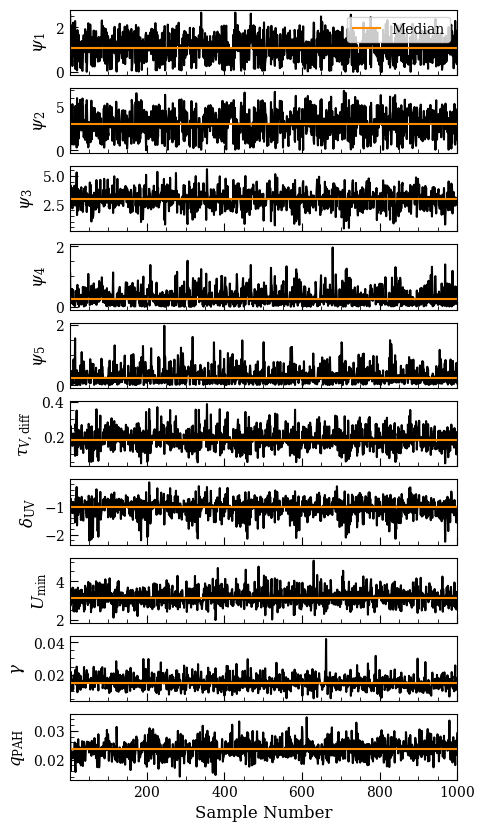

In [24]:
fig, axs = lgh.chain_plot(chain2)

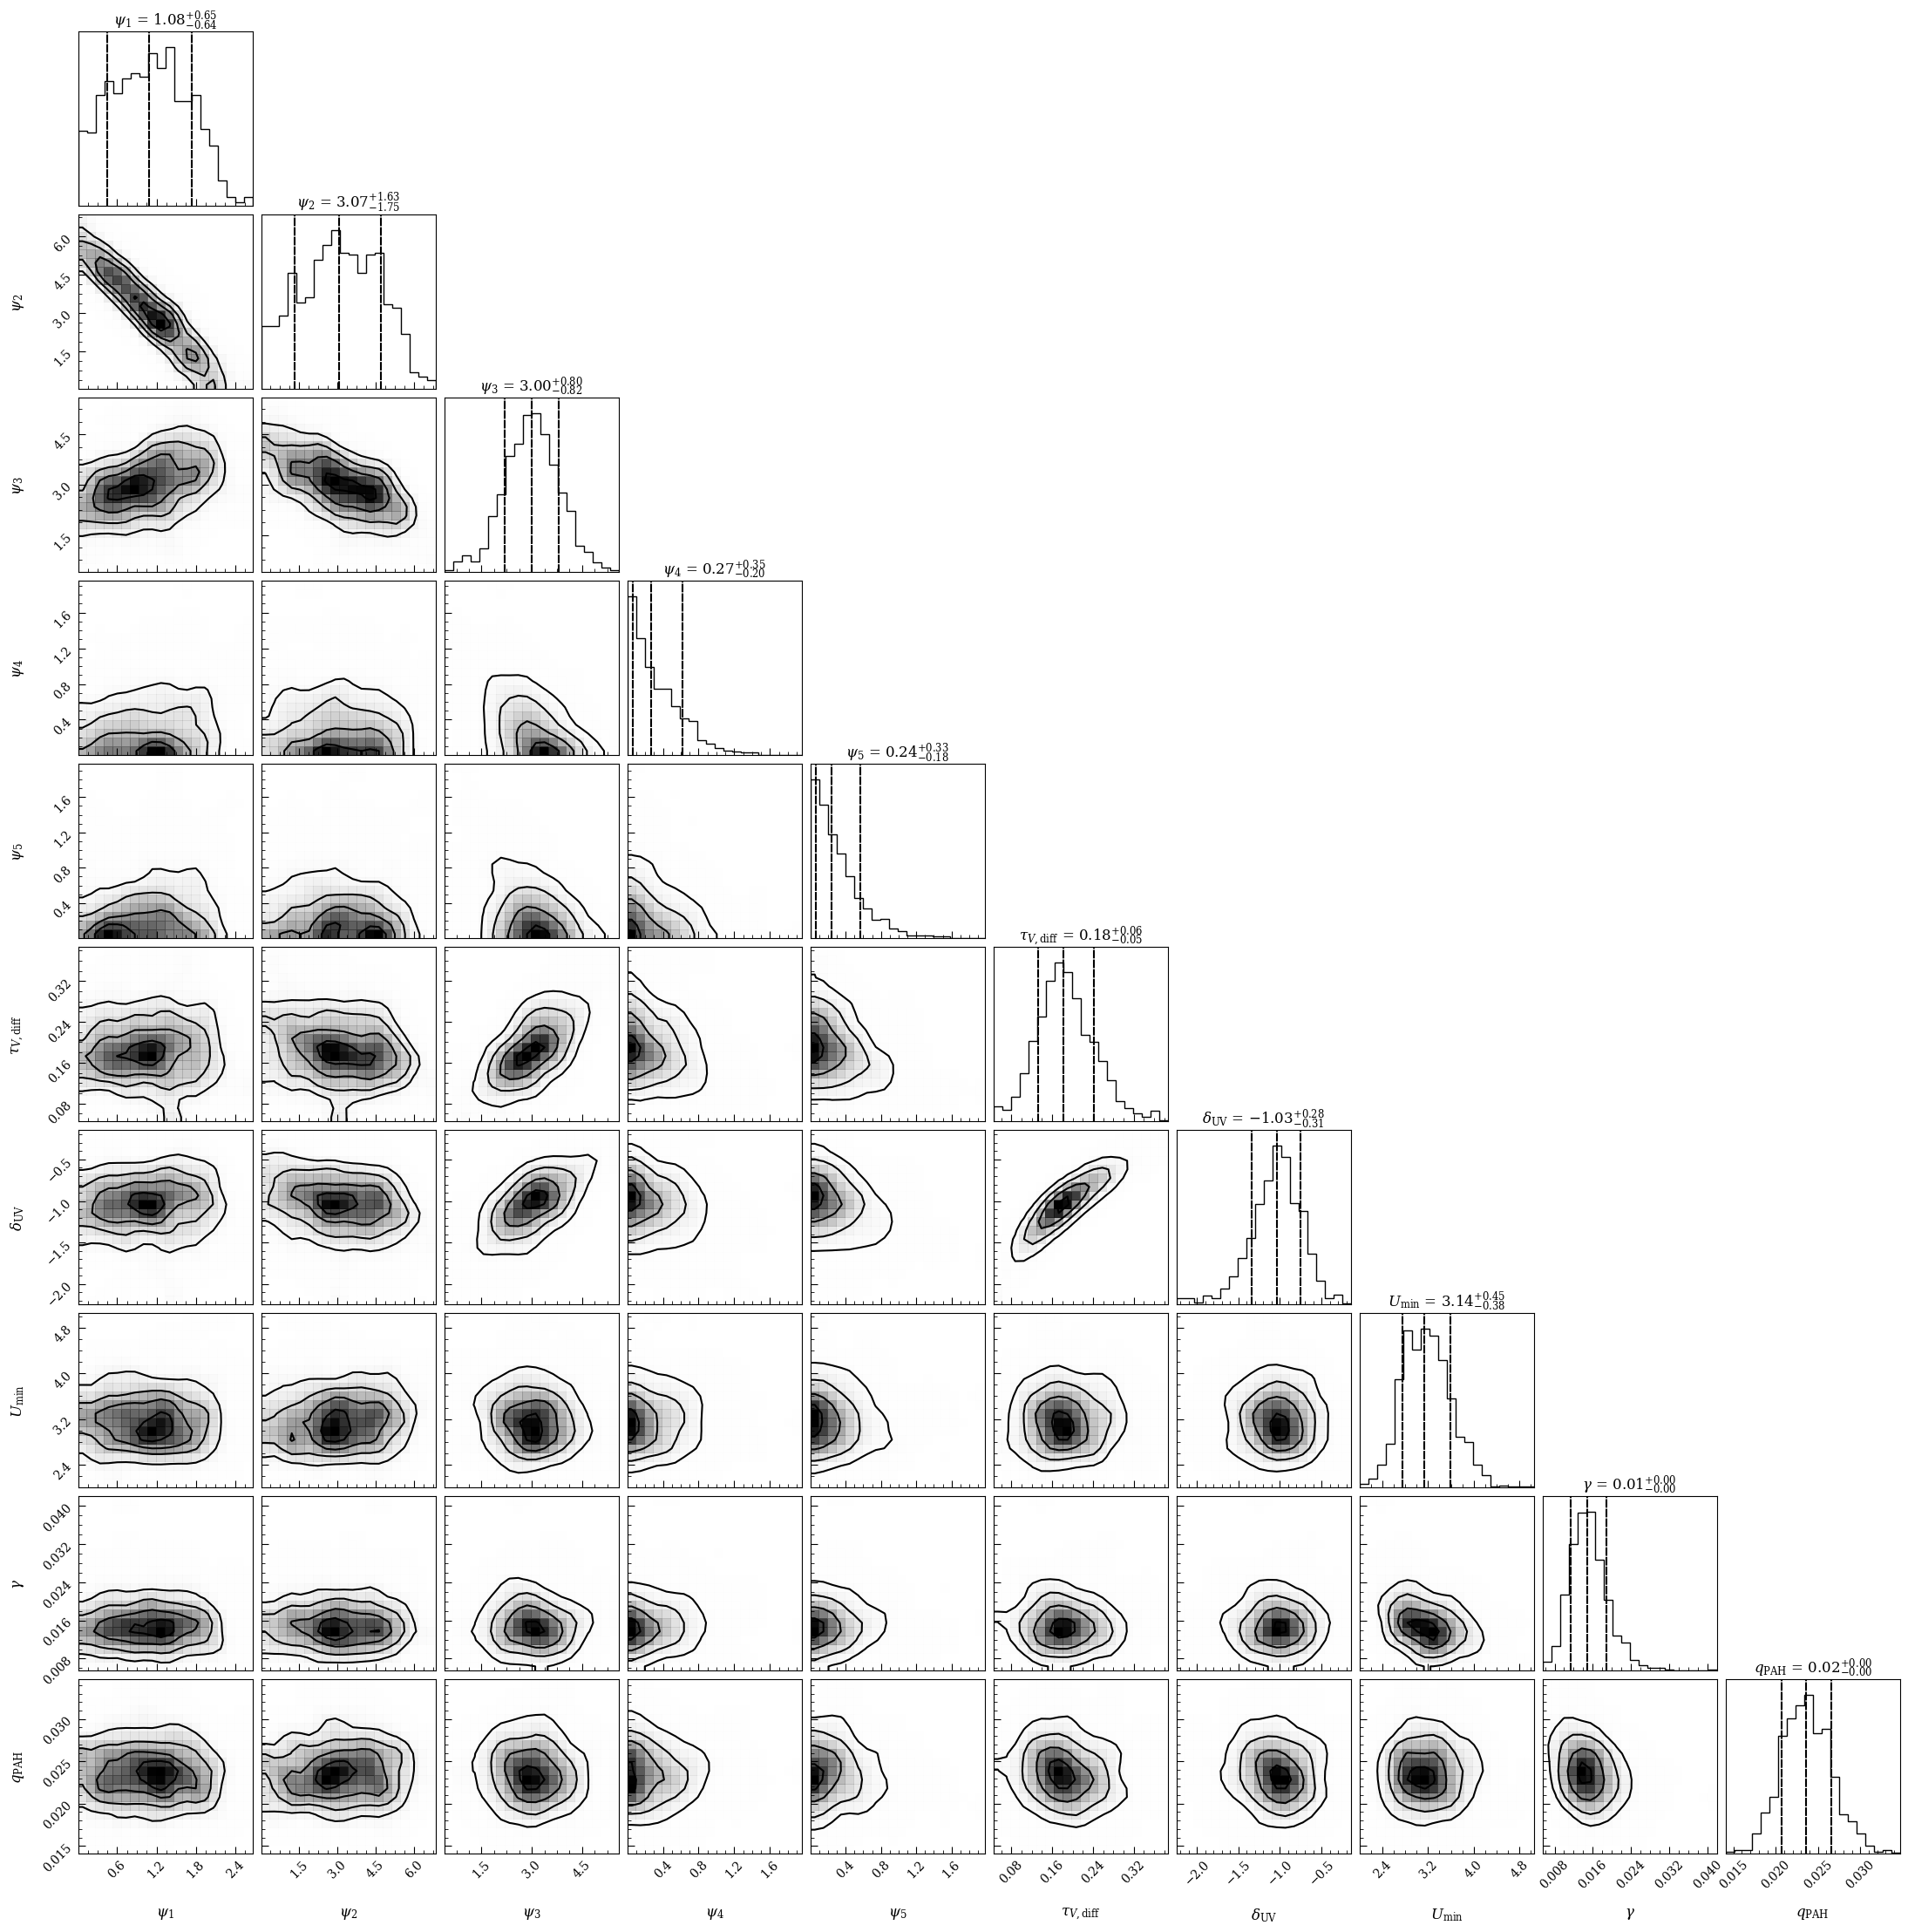

In [25]:
fig = lgh.corner_plot(chain2,
                     quantiles=(0.16, 0.50, 0.84),
                     smooth=1,
                     levels=None,
                     show_titles=True)

we can repeat the PPC analysis:

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/ppc.py:77: RuntimeWarning: invalid value encountered in divide
  chi2_rep = np.nansum((Lmod - Lmod_perturbed)**2 / total_unc2, axis=-1)


p = 0.821


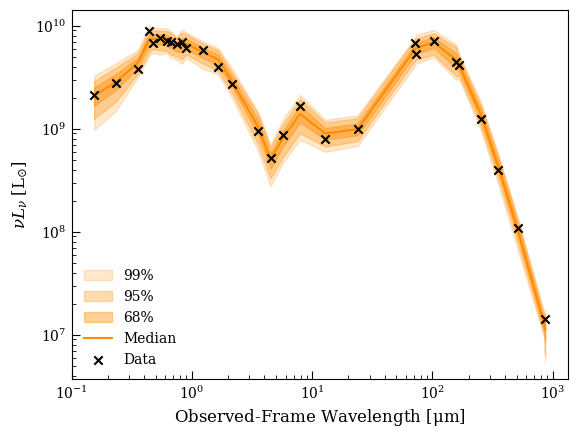

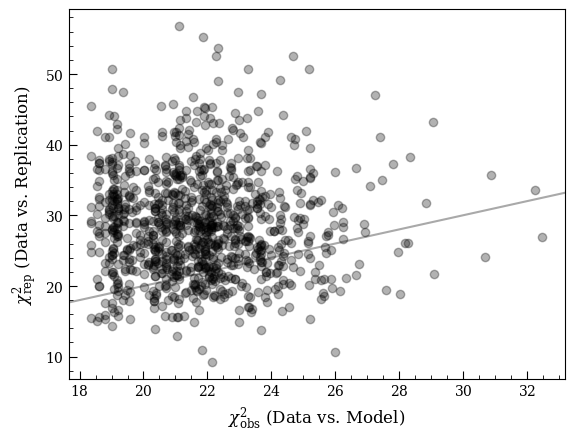

In [26]:
from lightning.ppc import ppc, ppc_sed
 
pvalue, chi2_rep, chi2_obs = ppc(lgh, chain2,
                                 logprob_chain2,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(lgh, chain2,
                  logprob_chain2,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

and get a remarkably similar result. We could save the results like so:

In [27]:
# with h5py.File('ngc337_mle_res.h5', 'w') as f:
#     f.create_dataset('mcmc/samples', data=chain2)
#     f.create_dataset('mcmc/logprob_samples', data=logprob_chain2)
#     f.create_dataset('res/bestfit', data=res.x)
#     f.create_dataset('res/chi2_best', data=res.fun * 2)